In [1]:
%%capture
%cd ..

In [2]:
import torch

from src.anomaly_detector.lstm import LSTM
from src.anomaly_detector.lstm_trainer import LSTMTrainer
from src.concept_drift_detector.concept_drift_detector import ConceptDriftDetector
from src.dataset import SifimDataset
from src.detector.model_selection import model_selection
from src.plot.timeseries_analysis import plot_with_thresholds
from src.utility import fix_seed, select_device, gridsearch_generator

fix_seed()
device = select_device()

In [3]:
# dataset
tr_dataset = SifimDataset(start=0.0, end=0.6)
vl_dataset = SifimDataset(start=0.6, end=0.8, test=True)
ts_dataset = SifimDataset(start=0.8, end=1.0, test=True, noise=0.01)
x_ts, y_ts = ts_dataset.x[:, :-1], ts_dataset.x[:, 1:]

In [4]:
# train concept anomaly_detector detector
lstm = model_selection(
    hyperparams_list=gridsearch_generator(
        model_hidden_state=[100],  # , 200, 300],
        model_ff_size=[300],  # , 500, 1000],
        model_window=[10],
        model_n_layers=[1],  # , 2, 3],
        model_bidirectional=[False],  # , True],
        trainer_epochs=[20],
    ),
    model_constructor=LSTM,
    trainer_constructor=LSTMTrainer,
    tr_dataset=tr_dataset,
    vl_dataset=vl_dataset,
    batch_size=32,
    shuffle=True,
    hyperparams_path='hyperparams/ad_hyperparams.json',
    model_path='models/lstm.torch',
    tqdm=None,
    retrain=True,
)


2023-11-17 18:33:29,177 - root - INFO - Start iteration 1/1 => hyperparams: {'model_hidden_state': 100, 'model_ff_size': 300, 'model_window': 10, 'model_n_layers': 1, 'model_bidirectional': False, 'trainer_epochs': 20}
2023-11-17 18:33:29,181 - root - INFO - Final best loss: 1.5119608818166937e-05, best hyperparams: {'model_hidden_state': 100, 'model_ff_size': 300, 'model_n_layers': 1, 'model_bidirectional': False, 'trainer_epochs': 20}


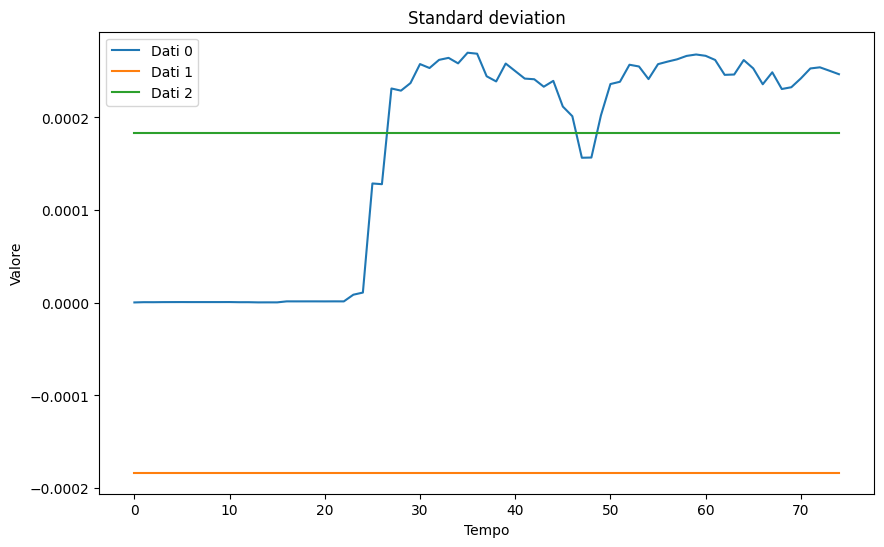

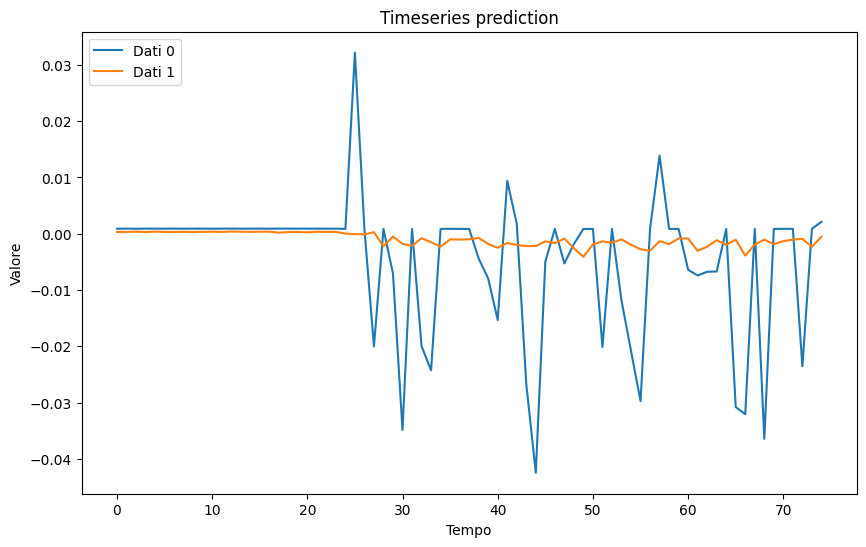

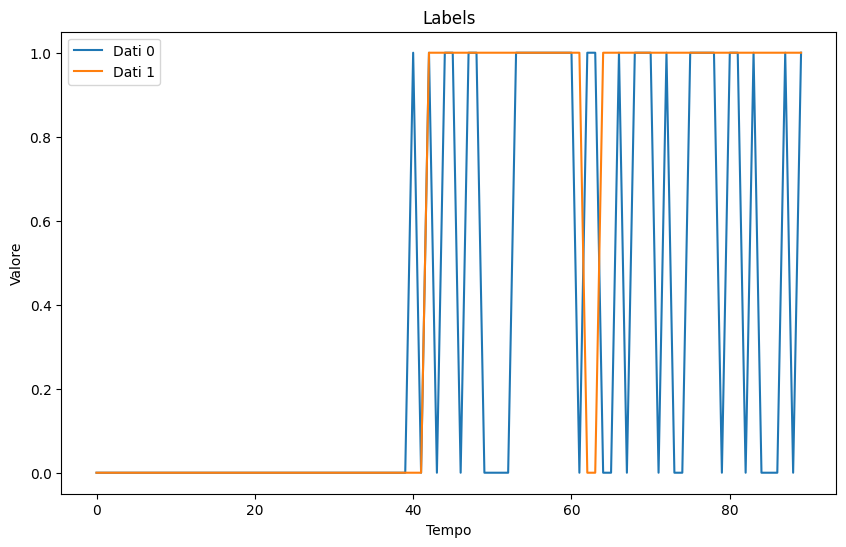

In [5]:
# test phase
ad_labels, ad_predictions, ad_std = lstm(x_ts, y_ts)

# plot
window = 75
i = 0
f = 0

std = ad_std[i, -window:]
m2s = torch.ones_like(std) * lstm.sigma.item() * (-2)
p2s = torch.ones_like(std) * lstm.sigma.item() * (+2)
plot_with_thresholds('Standard deviation', [std, m2s, p2s])  # standard deviation

y, p = ts_dataset.x[i, -window:, f], ad_predictions[i, -window:, f]
plot_with_thresholds('Timeseries prediction', [y, p])  # timeseries and prediction of lstm

plot_with_thresholds('Labels', [ts_dataset.y[i, -ad_labels.shape[1]:], ad_labels[i]])  # labels